In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai import *
import scipy.io
import numpy as np
import pandas as pd
import os
import cv2 as cv
import shutil
import random
import time
import matplotlib.pyplot as plt

In [3]:
!ls ../../data/simpsons

models	test  train


In [4]:
img_dir = '../../data/simpsons/'
path = Path(img_dir)
path

PosixPath('../../data/simpsons')

In [5]:
tfms = get_transforms(do_flip=True, 
                      flip_vert=True, 
                      max_zoom=1.1, 
                      max_lighting=0.3, 
                      max_warp=0.2, 
                      p_lighting=0.75)
batch_sz = 64  
image_sz = 224 # ResNet standard
SEED = 42

sub_df = pd.read_csv(f"../../data/sample_submission.csv")
test_df = pd.read_csv(f"../../data/sample_submission.csv")

In [6]:
data = ImageDataBunch.from_folder(img_dir+"/train", valid_pct=0.2, ds_tfms=tfms, 
                                  size=image_sz, bs=batch_sz, seed=SEED).normalize(imagenet_stats)
data.add_test(ImageList.from_df(test_df, img_dir, folder="test"))

In [7]:
data.classes

['abraham_grampa_simpson',
 'agnes_skinner',
 'apu_nahasapeemapetilon',
 'barney_gumble',
 'bart_simpson',
 'carl_carlson',
 'charles_montgomery_burns',
 'chief_wiggum',
 'cletus_spuckler',
 'comic_book_guy',
 'disco_stu',
 'edna_krabappel',
 'fat_tony',
 'gil',
 'groundskeeper_willie',
 'homer_simpson',
 'kent_brockman',
 'krusty_the_clown',
 'lenny_leonard',
 'lionel_hutz',
 'lisa_simpson',
 'maggie_simpson',
 'marge_simpson',
 'martin_prince',
 'mayor_quimby',
 'milhouse_van_houten',
 'miss_hoover',
 'moe_szyslak',
 'ned_flanders',
 'nelson_muntz',
 'otto_mann',
 'patty_bouvier',
 'principal_skinner',
 'professor_john_frink',
 'rainier_wolfcastle',
 'ralph_wiggum',
 'selma_bouvier',
 'sideshow_bob',
 'sideshow_mel',
 'snake_jailbird',
 'troy_mcclure',
 'waylon_smithers']

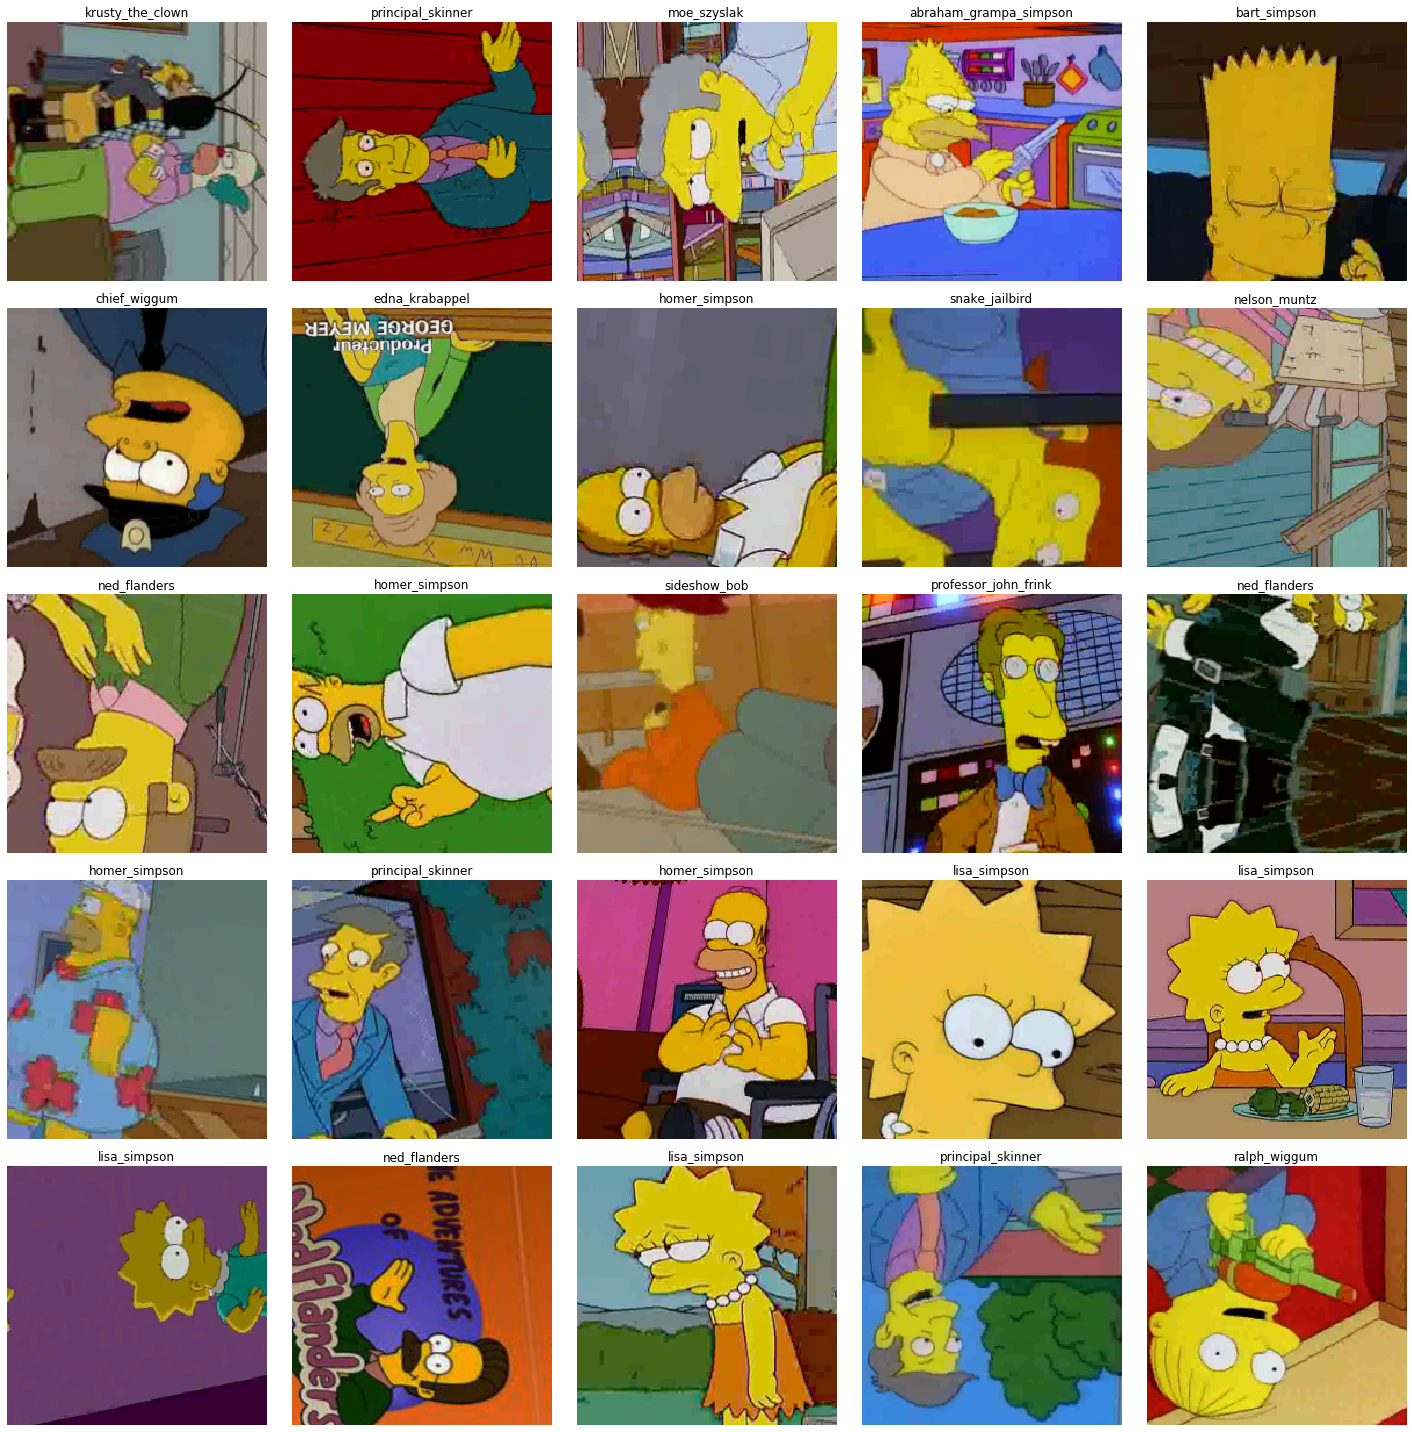

In [8]:
data.show_batch()

In [9]:
len(data.classes), data.c

(42, 42)

In [10]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [11]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,2.062170,1.222155,0.671749,01:11
1,1.223457,0.786542,0.785949,01:09
2,0.964169,0.645509,0.824514,01:09
3,0.857470,0.608167,0.833483,01:10


In [12]:
learn.unfreeze()
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy,time
0,0.621565,0.456142,0.872048,01:30
1,0.571581,0.589024,0.844245,01:32
2,0.504276,0.515565,0.863378,01:31
3,0.410996,0.357437,0.904634,01:32
4,0.317341,0.254358,0.934529,01:31
5,0.217916,0.166334,0.959043,01:31
6,0.136504,0.141949,0.965620,01:31
7,0.117182,0.136271,0.966517,01:32


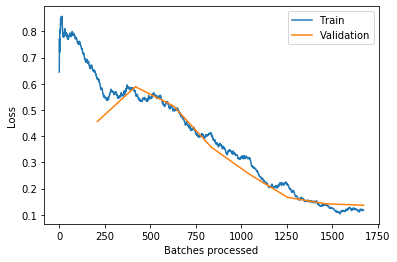

In [13]:
learn.recorder.plot_losses()

In [14]:
def get_interp(learn):
    interp = ClassificationInterpretation.from_learner(learn)
    losses,idxs = interp.top_losses()
    len(data.valid_ds)==len(losses)==len(idxs)
    return interp

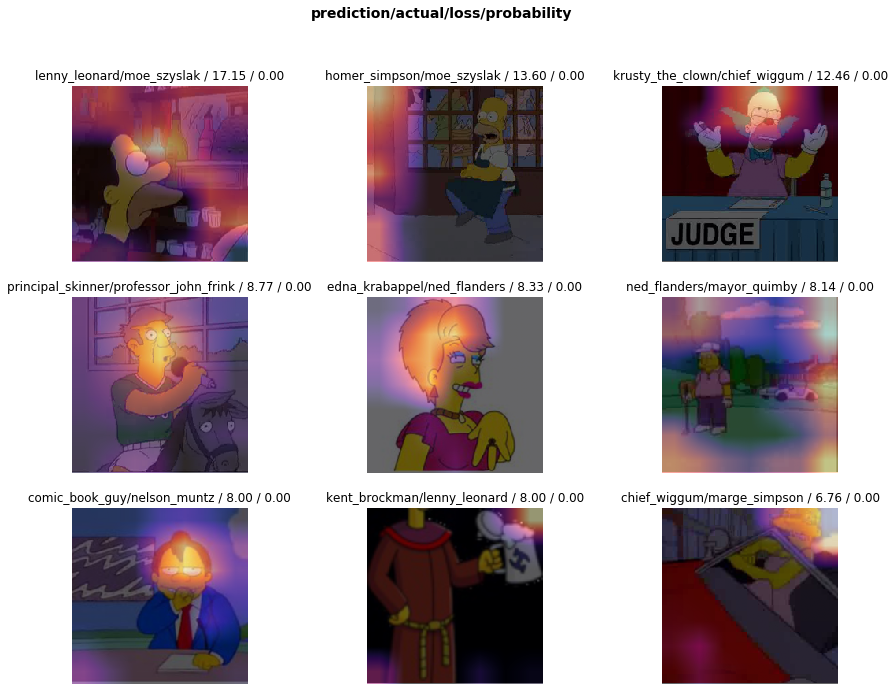

In [15]:
interp = get_interp(learn)
interp.plot_top_losses(9, figsize=(15,11))

In [18]:
interp.most_confused(min_val=3) # combinations that got confused 3 times or more.

[('maggie_simpson', 'lisa_simpson', 4), ('selma_bouvier', 'patty_bouvier', 4)]

In [21]:
learn.model_dir = Path(img_dir)

## Stage 2

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


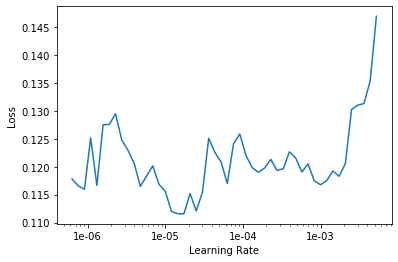

In [23]:
learn.recorder.plot()

In [24]:
learn.unfreeze()
learn.fit_one_cycle(16, max_lr=slice(3e-6,3e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.111926,0.134554,0.966816,01:28
1,0.107274,0.130271,0.965919,01:30
2,0.107451,0.129644,0.969208,01:32
3,0.092630,0.128311,0.968012,01:31
4,0.093533,0.133323,0.968012,01:32
5,0.088760,0.127986,0.969806,01:32
6,0.081918,0.125321,0.971599,01:32
7,0.075029,0.121907,0.971002,01:32
8,0.084070,0.122464,0.971002,01:32
9,0.063250,0.117494,0.971898,01:32


In [26]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [28]:
len(learn.layer_groups)

3

In [29]:
learn.freeze_to(2)
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.064491,0.143886,0.967115,01:08
1,0.083393,0.123197,0.970703,01:09
2,0.064143,0.126846,0.971002,01:10
3,0.054957,0.126502,0.971599,01:10


In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


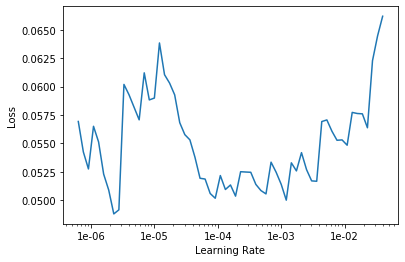

In [31]:
learn.recorder.plot()

In [33]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(2e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.051673,0.126219,0.971599,01:28
1,0.047352,0.131789,0.970404,01:31
2,0.059500,0.130319,0.971002,01:32
3,0.068096,0.132622,0.971599,01:32
4,0.057221,0.126044,0.971002,01:32
5,0.056830,0.131877,0.971599,01:32
6,0.048642,0.122741,0.973692,01:32
7,0.043664,0.120446,0.972795,01:32
8,0.040520,0.119794,0.973393,01:32
9,0.043235,0.121178,0.971898,01:32


In [34]:
learn.save('rn34_simpson_stage2')

## Prediction

In [35]:
test_probs, _ = learn.get_preds(ds_type=DatasetType.Test)
test_preds = [data.classes[pred] for pred in np.argmax(test_probs.numpy(), axis=-1)]

In [36]:
test_df = pd.read_csv(f"../../data/sample_submission.csv")
test_df.predicted_class = test_preds
test_df.to_csv("submission.csv", index=False)